In [2]:
import re
import gzip
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model

In [1]:
def readGz(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

## Loading Data

In [6]:
data = []
for l in readGz("data/renttherunway_final_data.json.gz"):
    data.append(l)
    
df = pd.DataFrame(data)

In [7]:
df.head()

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
0,28,hourglass,34d,romper,fit,"5' 8""",2260466,10,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36,straight & narrow,34b,gown,fit,"5' 6""",153475,10,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
2,116,NaN,NaN,sheath,fit,"5' 4""",1063761,10,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN
3,34,pear,34c,dress,fit,"5' 5""",126335,8,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27,athletic,34b,gown,fit,"5' 9""",616682,10,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs


## Data Cleaning

In [8]:
df.dtypes

age               object
body type         object
bust size         object
category          object
fit               object
height            object
item_id           object
rating            object
rented for        object
review_date       object
review_summary    object
review_text       object
size               int64
user_id           object
weight            object
dtype: object

In [9]:
def modify_height(row):
    height = row['height']
    if isinstance(height, float):
        return height
    lst = re.findall(r'\d+', height)
    return (int(lst[0]) * 12 + int(lst[1])) * 2.54

def modify_weight(row):
    weight = row['weight']
    if isinstance(weight, float):
        return weight
    return int(re.findall(r'\d+', weight)[0])

In [ ]:
#Modify height and weight to numbers
modified_height = df.apply(modify_height, axis = 1)
modified_weight = df.apply(modify_weight, axis = 1)

df['height(cm)'] = modified_height
df['modified_weight'] = modified_weight

df = df.drop(['height', 'weight'], axis = 1)

In [10]:
df.head()

,age,body type,bust size,category,fit,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,height(cm),modified_weight
0,28,hourglass,34d,romper,fit,2260466,10,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,172.72,137.0
1,36,straight & narrow,34b,gown,fit,153475,10,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,167.64,132.0
2,116,NaN,NaN,sheath,fit,1063761,10,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,162.56,NaN
3,34,pear,34c,dress,fit,126335,8,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,165.10,135.0
4,27,athletic,34b,gown,fit,616682,10,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,175.26,145.0


In [11]:
for val in df.columns:
    print('There are: ', sum(df[val].isnull()), ' null values in ', val)

There are:  960  null values in  age
There are:  14637  null values in  body type
There are:  18411  null values in  bust size
There are:  0  null values in  category
There are:  0  null values in  fit
There are:  0  null values in  item_id
There are:  82  null values in  rating
There are:  10  null values in  rented for
There are:  0  null values in  review_date
There are:  0  null values in  review_summary
There are:  0  null values in  review_text
There are:  0  null values in  size
There are:  0  null values in  user_id
There are:  677  null values in  height(cm)
There are:  29982  null values in  modified_weight


In [12]:
df.dropna(subset=['age','body type','bust size','rating','rented for','height(cm)','modified_weight'],inplace = True)

In [13]:
for val in df.columns:
    print('There are: ', sum(df[val].isnull()), ' null values in ', val)

There are:  0  null values in  age
There are:  0  null values in  body type
There are:  0  null values in  bust size
There are:  0  null values in  category
There are:  0  null values in  fit
There are:  0  null values in  item_id
There are:  0  null values in  rating
There are:  0  null values in  rented for
There are:  0  null values in  review_date
There are:  0  null values in  review_summary
There are:  0  null values in  review_text
There are:  0  null values in  size
There are:  0  null values in  user_id
There are:  0  null values in  height(cm)
There are:  0  null values in  modified_weight


In [14]:
df['age'] = df['age'].astype(float)
df['height(cm)'] = df['height(cm)'].astype(float)
df['size'] = df['size'].astype(float)
df['modified_weight'] = df['modified_weight'].astype(float)
df['rating'] = df['rating'].astype(float)

In [13]:
df['fit'].value_counts()

fit      107733
small     19622
large     19026
Name: fit, dtype: int64

In [14]:
df['fit'] = df['fit'].map({'fit': 1, 'small': 2,'large':3})

In [15]:
df_fit = df[df['fit']==1]
df_small = df[df['fit']==2]
df_large = df[df['fit']==3]

In [16]:
df['rented for'].value_counts()

wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: rented for, dtype: int64

In [17]:
df['rented for'] = df['rented for'].map({'wedding': 1, 'formal affair': 2,'party':3,
                                         'everyday':4,'work':5,'other':6,'date':7,'vacation':8,
                                         'party: cocktail':9})

In [18]:
df['body type'].value_counts()

hourglass            43982
athletic             37518
petite               19358
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64

In [19]:
df['body type'] = df['body type'].map({'hourglass': 1, 'athletic': 2,'petite':3,
                                         'pear':4,'straight & narrow':5,'full bust':6,'apple':7})

In [20]:
bust_size_count = df['bust size'].value_counts()
encoder={}
for i in range (len(bust_size_count)):
    encoder[bust_size_count.index[i]] = i
df['bust size'] = df['bust size'].map(encoder)

In [21]:
id_count = df['user_id'].value_counts()
encoder={}
for i in range (len(id_count)):
    encoder[id_count.index[i]] = i
df['user_id'] = df['user_id'].map(encoder)

In [22]:
df.head()

,age,body type,bust size,category,fit,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,height(cm),modified_weight
0,28.0,1,2,romper,1,2260466,10.0,8,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14.0,2492,172.72,137.0
1,36.0,5,0,gown,1,153475,10.0,6,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12.0,64240,167.64,132.0
3,34.0,4,1,dress,1,126335,8.0,2,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8.0,29280,165.10,135.0
4,27.0,2,0,gown,1,616682,10.0,1,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12.0,2300,175.26,145.0
5,45.0,2,5,dress,1,364092,8.0,7,"April 30, 2016",Traditional with a touch a sass,Didn't actually wear it. It fit perfectly. The...,8.0,33114,172.72,138.0


## EDA

#### general statistics

In [15]:
df.describe()

,age,rating,size,height(cm),modified_weight
count,146381.000000,146381.000000,146381.000000,146381.000000,146381.000000
mean,34.089800,9.081985,11.437919,165.768155,137.209870
std,8.113217,1.437853,7.826784,6.754444,21.540182
min,0.000000,2.000000,0.000000,137.160000,50.000000
25%,29.000000,8.000000,4.000000,160.020000,123.000000
50%,32.000000,10.000000,9.000000,165.100000,135.000000
75%,37.000000,10.000000,16.000000,170.180000,148.000000
max,117.000000,10.000000,58.000000,198.120000,300.000000


### Data type

In [24]:
data_column_type = pd.Series({'age':'numerical','body type':'categorical',
                             'bust size':'nominal','category':'categorical','fit':'categorical',
                             'height':'numerical','item_id':'nominal','rating':'ordinal',
                             'rented for':'categorical','review_date':'date','review_summary':'text',
                             'review_text':'text','size':'numerical','user_id':'nominal',
                             'weight':'numerical'}, name = 'type of data')

In [25]:
data_column_type.to_frame()

,type of data
age,numerical
body type,categorical
bust size,nominal
category,categorical
fit,categorical
height,numerical
item_id,nominal
rating,ordinal
rented for,categorical
review_date,date


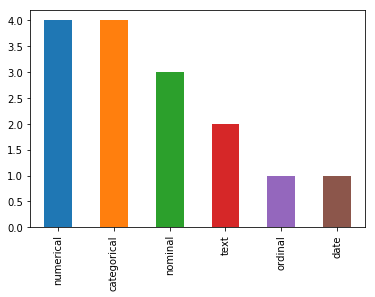

In [26]:
data_column_type.value_counts().plot(kind = 'bar')

#### rating only contains 2,4,6,8,10

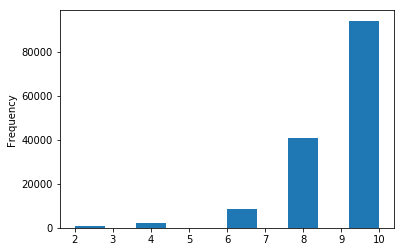

In [27]:
df.rating.plot(kind='hist')

##### Customers who found the clothing 'fit' seldom gives lower score

Text(0.5, 0, 'large')

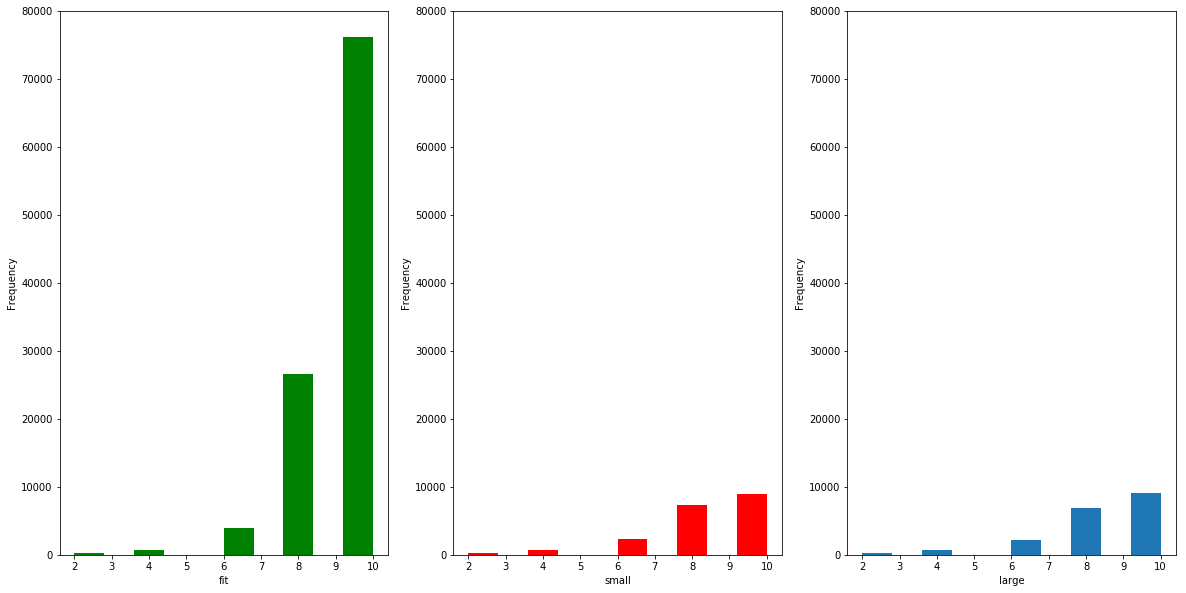

In [28]:
fg,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
ax1.set_ylim(0,80000)
ax2.set_ylim(0,80000)
ax3.set_ylim(0,80000)
df[df.fit==1].rating.plot(kind='hist',ax=ax1,color='g')
df[df.fit==2].rating.plot(kind='hist',ax=ax2,color='r')
df[df.fit==3].rating.plot(kind='hist',ax=ax3)
ax1.set_xlabel('fit')
ax2.set_xlabel('small')
ax3.set_xlabel('large')

#### rent cloth is popular among younger people

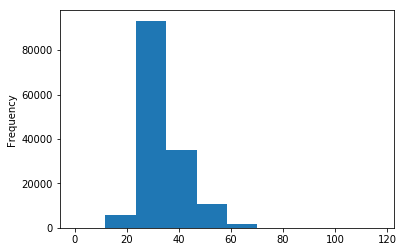

In [29]:
df['age'].plot(kind='hist')

### Heatmap-fit

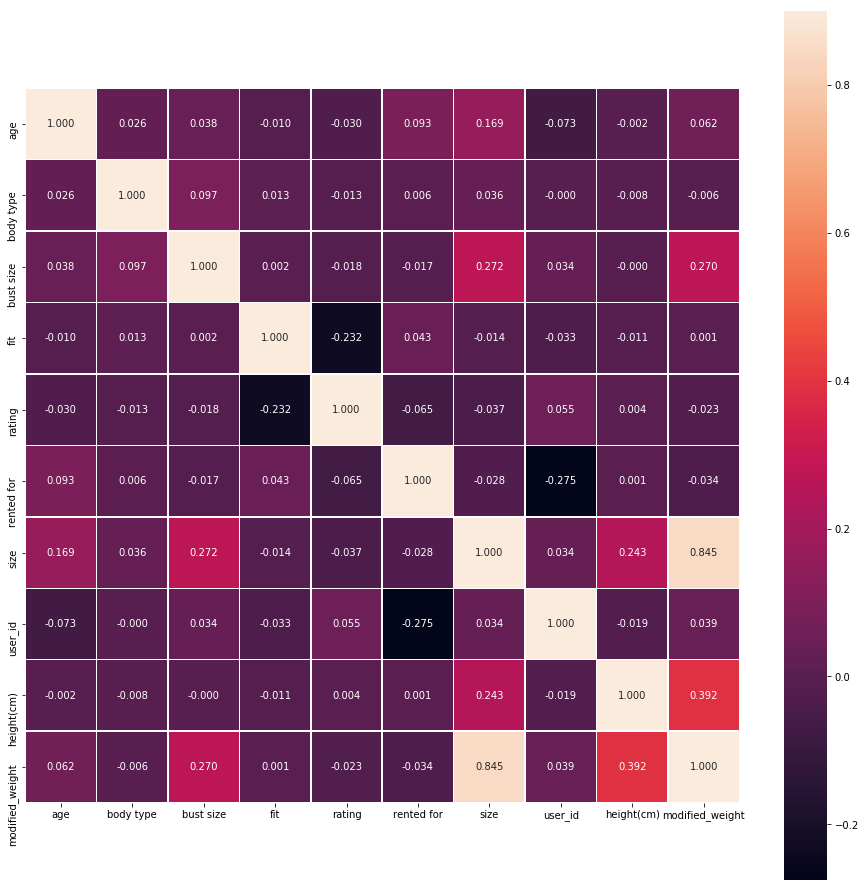

In [30]:
corr_map = df.corr()
plt.subplots(figsize=(16,16))
sns.heatmap(corr_map, vmax=0.9, square=True, fmt = '.3f', annot = True, linewidths = .5)

### train-test split

In [27]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size=0.33)

In [28]:
df_train.head()

,age,body type,bust size,category,fit,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,height(cm),modified_weight
9772,48.0,3,9,dress,1,129831,6.0,2,"November 7, 2016",Nice dress,"A little darker than I expected, but still rec...",4.0,6934,154.94,118.0
106853,35.0,2,1,sheath,1,1774617,10.0,7,"February 15, 2017",Sexy/chic,Looks very expensive and fits like perfection....,8.0,6162,167.64,125.0
181494,32.0,1,4,dress,1,627759,8.0,1,"August 21, 2017","Vibrant color, perfect for a summer wedding","The dress I received was a bit stretched out, ...",4.0,8897,165.10,113.0
172132,27.0,4,5,gown,1,145906,8.0,2,"April 16, 2014",I felt very comfortable all night!,"The dress was beautiful. It looked brand new,...",3.0,33755,160.02,120.0
30576,28.0,1,1,dress,3,532135,10.0,3,"November 20, 2016",Great Rehearsal Dinner Dress!,I wore this dress for my rehearsal and rehears...,12.0,22238,165.10,145.0


### baseline

In [29]:
mod = linear_model.LogisticRegression(C=1.0,class_weight='balanced')
mod.fit(df_train[['age','body type','bust size','rating','rented for','size','height(cm)','modified_weight']],df_train['fit'])


/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
pred = mod.predict(df_test[['age','body type','bust size','rating','rented for','size','height(cm)','modified_weight']])

In [31]:
sum(pred==df_test['fit'])/len(df_test)

0.7123959756551981

In [32]:
pd.Series(pred).value_counts()

1    42092
2     4097
3     2117
dtype: int64

### TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(df_train['review_text'])

In [34]:
mod_tfidf = linear_model.LogisticRegression(C=1.0,class_weight='balanced')
mod_tfidf.fit(X_train,df_train['fit'])

/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
X_test = vectorizer.transform(df_test['review_text'])
pred_tfidf = mod_tfidf.predict(X_test)

In [36]:
#For later emsemble learning pp
pred_tfidf_train= mod_tfidf.predict(X_train)

In [37]:
sum(pred_tfidf==df_test['fit'])/len(df_test)

0.7755144288494183

### TF-IDF + Baseline

In [38]:
X_concat = df_train[['age','body type','bust size','rating','rented for','size','height(cm)','modified_weight']]
X_concat = np.concatenate([X_concat,X_train.toarray()],axis = 1)

In [39]:
X_concat_test = df_test[['age','body type','bust size','rating','rented for','size','height(cm)','modified_weight']]
X_concat_test = np.concatenate([X_concat_test,X_test.toarray()],axis = 1)

In [40]:
mod_concat = linear_model.LogisticRegression(C=1.0,class_weight='balanced')
mod_concat.fit(X_concat,df_train['fit'])

/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
pred_concat = mod_concat.predict(X_concat_test)

In [42]:
sum(pred_concat==df_test['fit'])/len(df_test)

0.7859479153728315

### TF-IDF + Baseline Prediction

In [43]:
pred_train = mod.predict(df_train[['age','body type','bust size','rating','rented for','size','height(cm)','modified_weight']])
X_concat_pred= np.concatenate((X_train.toarray(), pred_train.reshape(-1,1)), axis=1)

In [44]:
x_concat_pred_test = np.concatenate((X_test.toarray(), pred.reshape(-1,1)), axis=1)

In [45]:
mod_concat_pred = linear_model.LogisticRegression(C=1.0,class_weight='balanced')
mod_concat_pred.fit(X_concat_pred,df_train['fit'])

/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
pred_p_concat = mod_concat_pred.predict(x_concat_pred_test)

In [47]:
sum(pred_p_concat==df_test['fit'])/len(df_test)

0.7774603568914834

### TF-IDF Prediction + Baseline Prediction

In [48]:
X_pp = np.vstack((pred_tfidf_train,pred_train)).T

In [49]:
X_pp_test = np.vstack((pred_tfidf,pred)).T

In [50]:
mod_pp = linear_model.LogisticRegression(C=1.0,class_weight='balanced')
mod_pp.fit(X_pp,df_train['fit'])

/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
pred_pp = mod_pp.predict(X_pp_test)

In [52]:
sum(pred_pp==df_test['fit'])/len(df_test)

0.7731751749265101